In [58]:
import pandas as pd
import requests as r
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

<h3> Monthly Data </h3>

In [59]:
api_key = "aBIdeyJp18dnYHxOLyICUOdCfrz7C2g1VFRdCQbx"

In [60]:
solar_monthly_url = f"https://api.eia.gov/v2/electricity/electric-power-operational-data/data/?frequency=monthly&data[0]=generation&facets[fueltypeid][]=SPV&facets[location][]=MO&facets[sectorid][]=99&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"
wind_monthly_url = f"https://api.eia.gov/v2/electricity/electric-power-operational-data/data/?frequency=monthly&data[0]=generation&facets[fueltypeid][]=WND&facets[location][]=MO&facets[sectorid][]=99&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"

In [61]:
def eia_api_query_to_dataframe(url,hourly=False):
### This function creates a properly formatted data frame starting with an api query    
    try:
        (request := r.get(url))
    except Exception as e:
        print(e)
    json_data = request.json()
    dataframe = pd.DataFrame(json_data.get('response').get('data'))
    if hourly == True:
        dataframe.period = pd.to_datetime(dataframe.period,utc=True)
    else:
        dataframe.period = pd.to_datetime(dataframe.period)
    
    
    return dataframe
    

In [62]:
solar_generation = eia_api_query_to_dataframe(solar_monthly_url)

In [63]:
solar_generation.head()

,period,location,stateDescription,sectorid,sectorDescription,fueltypeid,fuelTypeDescription,generation,generation-units
0,2023-01-01,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,9.56056,thousand megawatthours
1,2022-12-01,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,7.20169,thousand megawatthours
2,2022-11-01,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,9.47591,thousand megawatthours
3,2022-10-01,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,14.40455,thousand megawatthours
4,2022-09-01,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,15.42541,thousand megawatthours


<AxesSubplot:xlabel='period', ylabel='generation'>

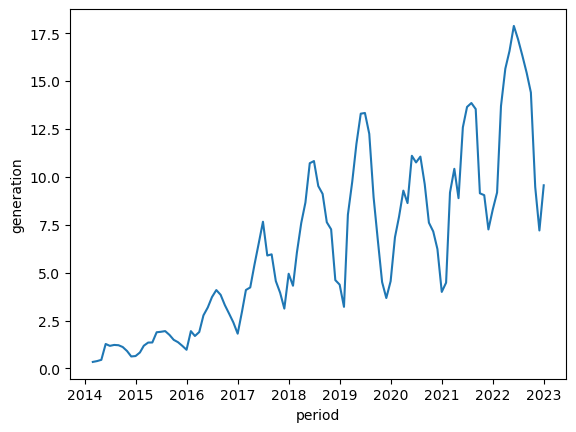

In [64]:
sns.lineplot(x="period",y="generation",data=solar_generation)

In [65]:
index=pd.DatetimeIndex(solar_generation.period).to_period("M")
y = pd.Series(solar_generation.generation.values, index=index)
arima = ARIMA(y,order=(2,0,2)).fit()

C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [66]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  107
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -191.038
Date:                Fri, 14 Apr 2023   AIC                            394.076
Time:                        13:02:22   BIC                            410.113
Sample:                             0   HQIC                           400.577
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4249      2.181      2.945      0.003       2.150      10.700
ar.L1          1.3939      0.278      5.023      0.000       0.850       1.938
ar.L2         -0.4780      0.261     -1.829      0.0

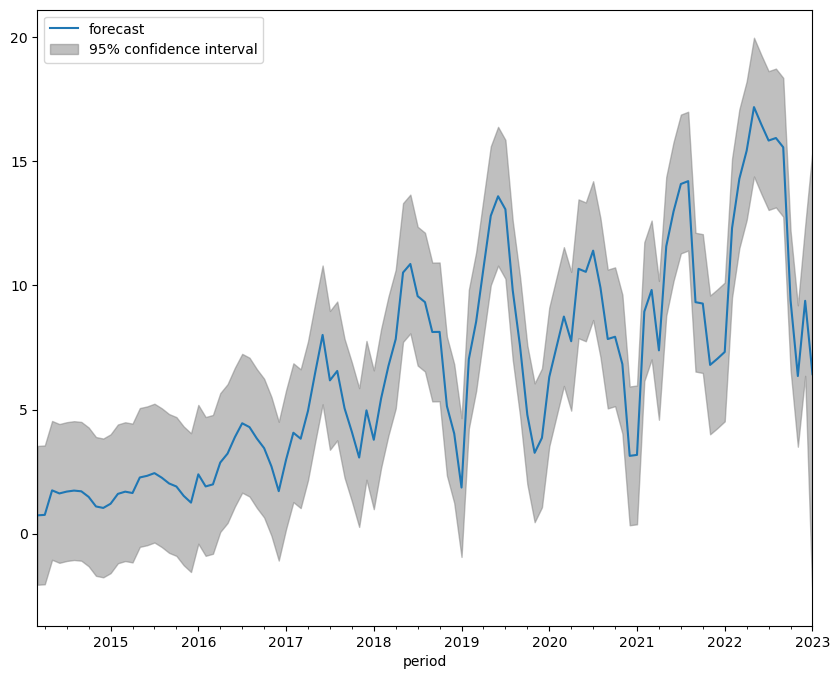

In [67]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(arima, ax=ax)
legend = ax.legend(loc="upper left")

In [68]:
sarimax = SARIMAX(y,order=(2,0,2),seasonal_order=(2,0,2,12)).fit()

C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [69]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  107
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 12)   Log Likelihood                -178.096
Date:                            Fri, 14 Apr 2023   AIC                            374.192
Time:                                    13:02:23   BIC                            398.247
Sample:                                         0   HQIC                           383.944
                                            - 107                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2224      0.472      0.471      0.638      -0.703       1.148
ar.L2          0.6790      0.434      1.564      0.118      -0.172       1.530
ma.L1          0.7592      0.480      1.582      0.114      -0.182       1.700
ma.L2          0.0988      0.112      0.884      0.377      -0.120       0.318
ar.S.L12      -0.0374      4.508     -0.008      0.993      -8.874       8.799
ar.S.L24       0.8338      3.933      0.212      0.832      -6.875       8.543
ma.S.L12       0.4142      4.685      0.088      0.930      -8.768       9.596
ma.S.L24      -0.5070      2.260     -0.224      0.822      -4.936       3.922
sigma2         1.4756      0.273      5.402      0.000       0.940       2.011
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                12.46
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

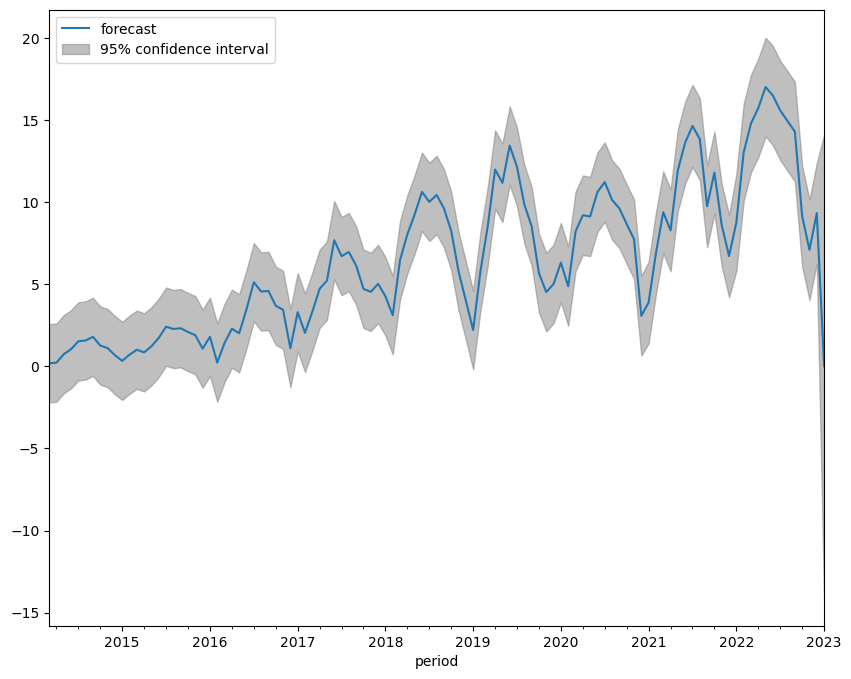

In [70]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(sarimax, ax=ax)
legend = ax.legend(loc="upper left")

In [71]:
wind_generation = eia_api_query_to_dataframe(wind_monthly_url)

In [72]:
wind_generation.head()

,period,location,stateDescription,sectorid,sectorDescription,fueltypeid,fuelTypeDescription,generation,generation-units
0,2023-01-01,MO,Missouri,99,All Sectors,WND,wind,664.16199,thousand megawatthours
1,2022-12-01,MO,Missouri,99,All Sectors,WND,wind,765.94774,thousand megawatthours
2,2022-11-01,MO,Missouri,99,All Sectors,WND,wind,794.67596,thousand megawatthours
3,2022-10-01,MO,Missouri,99,All Sectors,WND,wind,568.17608,thousand megawatthours
4,2022-09-01,MO,Missouri,99,All Sectors,WND,wind,468.58903,thousand megawatthours


In [73]:
wind_generation.period = pd.to_datetime(wind_generation.period)

<AxesSubplot:xlabel='period', ylabel='generation'>

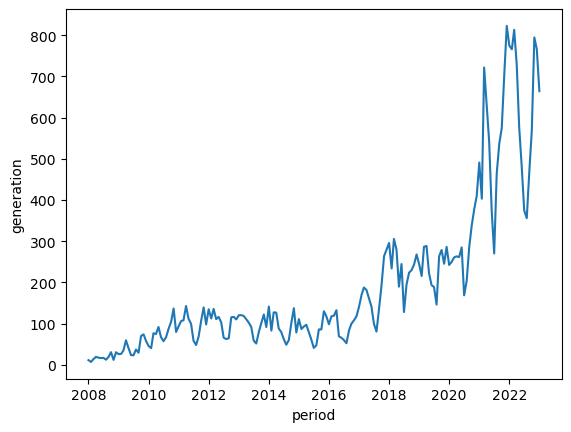

In [74]:
sns.lineplot(x="period",y="generation",data=wind_generation)

<h3> Hourly Prediction </h3>

In [75]:
solar_hourly_url = f"https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?frequency=hourly&data[0]=value&facets[fueltype][]=SUN&facets[respondent][]=MISO&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"
wind_hourly_url = f"https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?frequency=hourly&data[0]=value&facets[respondent][]=MISO&facets[fueltype][]=WND&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"

In [76]:
hourly_solar_generation = eia_api_query_to_dataframe(solar_hourly_url,hourly=True)

In [77]:
hourly_solar_generation.head()

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2023-04-14 05:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
1,2023-04-14 04:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
2,2023-04-14 03:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
3,2023-04-14 02:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
4,2023-04-14 01:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,70,megawatthours


<AxesSubplot:xlabel='period', ylabel='value'>

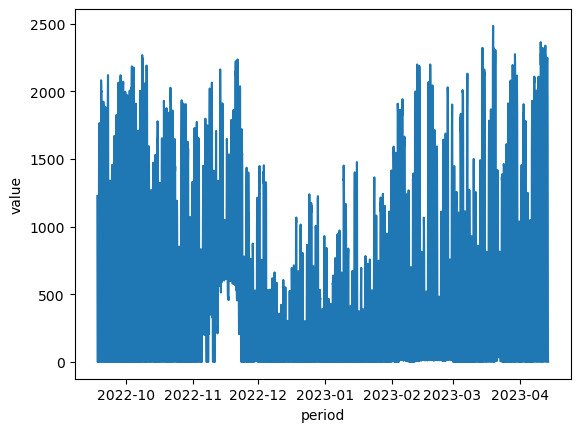

In [78]:
sns.lineplot(x="period",y="value",data=hourly_solar_generation)

In [79]:
hourly_wind_generation = eia_api_query_to_dataframe(wind_hourly_url,hourly=True)

In [80]:
hourly_wind_generation.head()

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2023-04-14 05:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,15517,megawatthours
1,2023-04-14 04:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,16594,megawatthours
2,2023-04-14 03:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,17350,megawatthours
3,2023-04-14 02:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,17509,megawatthours
4,2023-04-14 01:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,16607,megawatthours


<AxesSubplot:xlabel='period', ylabel='value'>

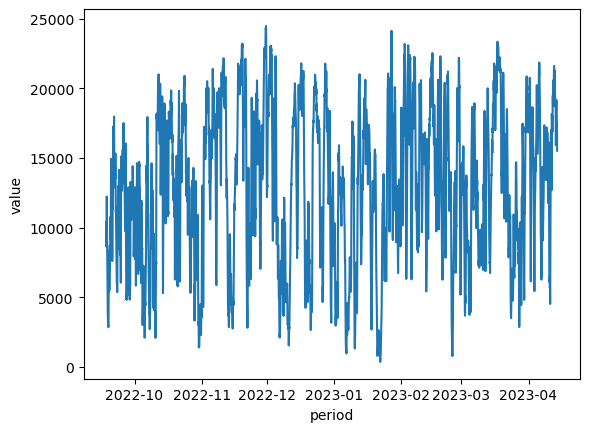

In [81]:
sns.lineplot(x="period",y="value",data=hourly_wind_generation)

<h3> Weather Data </h3>

In [82]:
date = str(datetime.date.today())

hourly_weather_url = f"https://archive-api.open-meteo.com/v1/archive?latitude=38.63&longitude=-90.20&start_date=2022-06-01&end_date={date}&hourly=temperature_2m,cloudcover,windspeed_10m"

In [83]:
try:
    (request := r.get(hourly_weather_url))
except Exception as e:
    print(e)

In [84]:
hourly_weather = pd.DataFrame(request.json().get("hourly"))

In [85]:
hourly_weather.time = pd.to_datetime(hourly_weather.time,utc=True)

<h3> Merge data sets </h3>

In [115]:
solar_weather = hourly_solar_generation.merge(hourly_weather,left_on="period" ,right_on="time",how="inner")

In [116]:
solar_weather.set_index("period", inplace=True)

In [117]:
solar_weather.head()

,respondent,respondent-name,fueltype,type-name,value,value-units,time,temperature_2m,cloudcover,windspeed_10m
period,,,,,,,,,,
2023-04-14 05:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours,2023-04-14 05:00:00+00:00,NaN,NaN,NaN
2023-04-14 04:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours,2023-04-14 04:00:00+00:00,NaN,NaN,NaN
2023-04-14 03:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours,2023-04-14 03:00:00+00:00,NaN,NaN,NaN
2023-04-14 02:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours,2023-04-14 02:00:00+00:00,NaN,NaN,NaN
2023-04-14 01:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,70,megawatthours,2023-04-14 01:00:00+00:00,NaN,NaN,NaN


<h3> Set up LSTM Prediction of Hourly Solar Data </h3>

In [118]:
def build_3D_Array(dataframe, n_future=1,n_past=24):
    train_X = []
    train_y = []
    
    for i in range(n_past, len(dataframe) - n_future + 1):
        train_X.append(dataframe[i - n_past:i, 0:dataframe.shape[1]])
        train_y.append(dataframe[i + n_future - 1:i + n_future, 0])
    train_X, train_y = np.array(train_X), np.array(train_y)
    
    return train_X, train_y

In [119]:
def preprocess_data(dataframe,columns_to_drop):
    train_X = []
    train_y = []
    
    dataframe = dataframe.drop(columns_to_drop,axis=1)
    dataframe = dataframe.dropna()
    scaler = MinMaxScaler()
    dataframe = scaler.fit_transform(dataframe)
    train_X, train_y = build_3D_Array(dataframe)
    return train_X,train_y

In [120]:
columns_to_drop = ["respondent","respondent-name","fueltype","type-name","time","windspeed_10m","value-units"]
train_X, train_y = preprocess_data(solar_weather,columns_to_drop)

In [121]:
model=Sequential()
model.add(LSTM(50,input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dense(1))
model.compile(loss="mae",optimizer="adam")

In [122]:
history = model.fit(train_X, train_y, epochs=50, batch_size=3,validation_split=0.1)

Epoch 1/50
1448/1448 [==============================] - 14s 8ms/step - loss: 0.0672 - val_loss: 0.0522
Epoch 2/50
1448/1448 [==============================] - 13s 9ms/step - loss: 0.0351 - val_loss: 0.0326
Epoch 3/50
1448/1448 [==============================] - 19s 13ms/step - loss: 0.0293 - val_loss: 0.0314
Epoch 4/50
1448/1448 [==============================] - 19s 13ms/step - loss: 0.0274 - val_loss: 0.0449
Epoch 5/50
1448/1448 [==============================] - 19s 13ms/step - loss: 0.0254 - val_loss: 0.0279
Epoch 6/50
1448/1448 [==============================] - 18s 12ms/step - loss: 0.0241 - val_loss: 0.0276
Epoch 7/50
1448/1448 [==============================] - 18s 12ms/step - loss: 0.0236 - val_loss: 0.0285
Epoch 8/50
1448/1448 [==============================] - 18s 12ms/step - loss: 0.0225 - val_loss: 0.0248
Epoch 9/50
1448/1448 [==============================] - 18s 12ms/step - loss: 0.0220 - val_loss: 0.0269
Epoch 10/50
1448/1448 [==============================] - 18s 12ms/

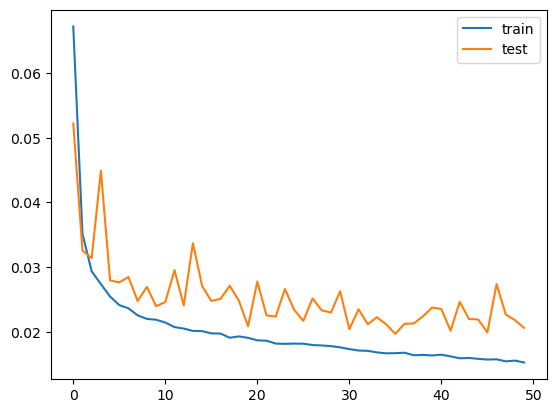

In [123]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [124]:
y_pred_train = model.predict(train_X)

151/151 [==============================] - 2s 6ms/step


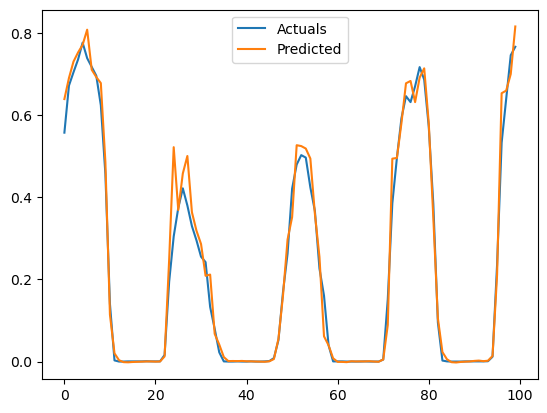

In [127]:
plt.plot(pd.Series(train_y[0:100,0]), label="Actuals")
plt.plot(pd.Series(y_pred_train[0:100,0]), label="Predicted")
plt.legend()
plt.show()

<h3> Wind Prediction </h3>

In [128]:
wind_weather = hourly_wind_generation.merge(hourly_weather,left_on="period" ,right_on="time",how="inner")

In [129]:
wind_weather.set_index("period", inplace=True)

In [130]:
wind_weather.head()

,respondent,respondent-name,fueltype,type-name,value,value-units,time,temperature_2m,cloudcover,windspeed_10m
period,,,,,,,,,,
2023-04-14 05:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,15517,megawatthours,2023-04-14 05:00:00+00:00,NaN,NaN,NaN
2023-04-14 04:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,16594,megawatthours,2023-04-14 04:00:00+00:00,NaN,NaN,NaN
2023-04-14 03:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,17350,megawatthours,2023-04-14 03:00:00+00:00,NaN,NaN,NaN
2023-04-14 02:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,17509,megawatthours,2023-04-14 02:00:00+00:00,NaN,NaN,NaN
2023-04-14 01:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,16607,megawatthours,2023-04-14 01:00:00+00:00,NaN,NaN,NaN


In [132]:
columns_to_drop = ["respondent","respondent-name","fueltype","type-name","time","value-units","temperature_2m","cloudcover"]
train_X,train_y = preprocess_data(wind_weather, columns_to_drop)

In [133]:
model_wind=Sequential()
model_wind.add(LSTM(50,input_shape=(train_X.shape[1],train_X.shape[2])))
model_wind.add(Dense(1))
model_wind.compile(loss="mae",optimizer="adam")

In [134]:
history_wind = model_wind.fit(train_X, train_y, epochs=50, batch_size=3,validation_split=0.1)

Epoch 1/50
1448/1448 [==============================] - 21s 13ms/step - loss: 0.0586 - val_loss: 0.0362
Epoch 2/50
1448/1448 [==============================] - 18s 13ms/step - loss: 0.0254 - val_loss: 0.0258
Epoch 3/50
1448/1448 [==============================] - 18s 13ms/step - loss: 0.0204 - val_loss: 0.0228
Epoch 4/50
1448/1448 [==============================] - 19s 13ms/step - loss: 0.0196 - val_loss: 0.0223
Epoch 5/50
1448/1448 [==============================] - 19s 13ms/step - loss: 0.0189 - val_loss: 0.0222
Epoch 6/50
1448/1448 [==============================] - 18s 13ms/step - loss: 0.0191 - val_loss: 0.0247
Epoch 7/50
1448/1448 [==============================] - 18s 13ms/step - loss: 0.0189 - val_loss: 0.0217
Epoch 8/50
1448/1448 [==============================] - 19s 13ms/step - loss: 0.0186 - val_loss: 0.0228
Epoch 9/50
1448/1448 [==============================] - 20s 14ms/step - loss: 0.0186 - val_loss: 0.0220
Epoch 10/50
1448/1448 [==============================] - 20s 14m

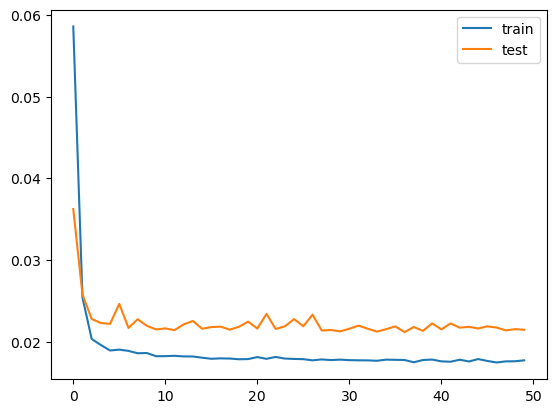

In [135]:
plt.plot(history_wind.history["loss"], label="train")
plt.plot(history_wind.history["val_loss"], label="test")
plt.legend()
plt.show()

In [137]:
y_pred_train = model_wind.predict(train_X)

151/151 [==============================] - 1s 3ms/step


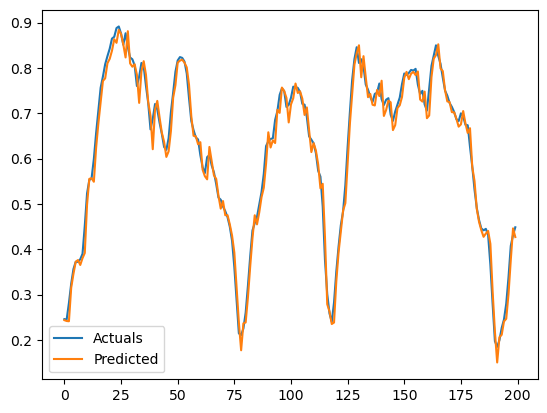

In [139]:
plt.plot(pd.Series(train_y[0:200,0]), label="Actuals")
plt.plot(pd.Series(y_pred_train[0:200,0]), label="Predicted")
plt.legend()
plt.show()

<h3> Forecasted Weather </h3>

In [141]:
hourly_forecast_url = "https://api.open-meteo.com/v1/forecast?latitude=38.63&longitude=-90.20&hourly=temperature_2m,cloudcover,windspeed_10m"

In [142]:
try:
    (request := r.get(hourly_forecast_url))
except Exception as e:
    print(e)